# Simple Vizualisation
*Ce notebook crée quelques graphiques simples pour montrer certains liens*

In [1]:
from ift6758.data import summarize_shots_and_goals_by_shot_type, load_cached_season_dataframe

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style="ticks")

*Ici on choisit quelle saison on veut grapher (par exemple 2023 ici), si on veut observer une autre saison il faut simplement changer la valeur de season*

In [2]:
season = 2023
play_df = load_cached_season_dataframe(season, game_types=(2,3))

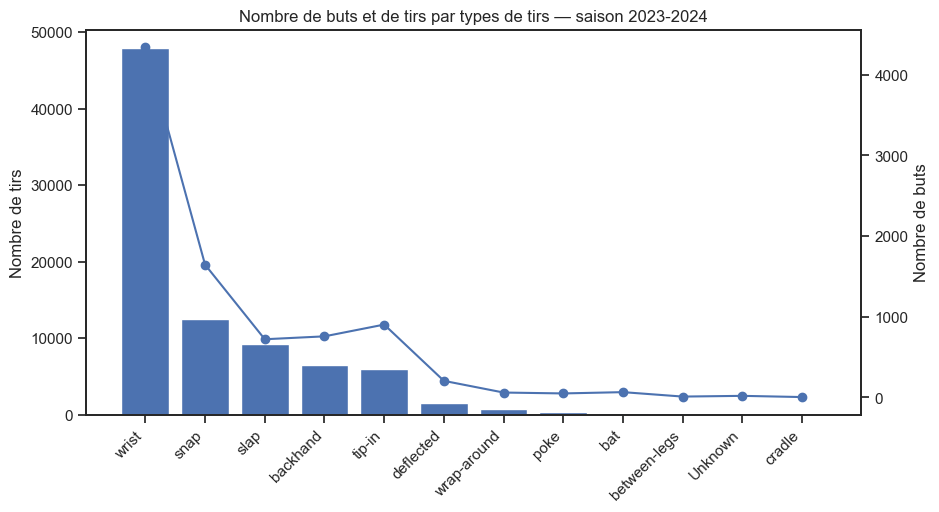

In [3]:
shot_type_summary = summarize_shots_and_goals_by_shot_type(play_df)

figure, primary_axis = plt.subplots(figsize=(10, 5))
bar_positions = np.arange(len(shot_type_summary))

# Barres = nombre total de tirs (incluant les goals)
primary_axis.bar(bar_positions, shot_type_summary["shots"])
primary_axis.set_xticks(bar_positions)
primary_axis.set_xticklabels(shot_type_summary["typeShot"], rotation=45, ha="right")
primary_axis.set_ylabel("Nombre de tirs")
primary_axis.set_title(
    f"Nombre de buts et de tirs par types de tirs — saison {season}-{season+1}"
)

# Ligne = nombre de buts (axe secondaire)
secondary_axis = primary_axis.twinx()
secondary_axis.plot(bar_positions, shot_type_summary["goals"], marker="o")
secondary_axis.set_ylabel("Nombre de buts")

plt.show()

# Droite de la probabilité d'un but selon la distance de tir, avec en arrière plan un histogramme indiquant le nombre de tir


In [4]:
SHOT_LIKE = {"shot-on-goal", "goal", "missed-shot"}

# 1) On déduit le côté d’attaque par (game, period, team) avec la médiane de x
teamCol   = "teamShot"
periodCol = "period"
gameCol   = "gameId"

shots_for_side = play_df[play_df["typeEvent"].isin(SHOT_LIKE) & play_df["x"].notna()].copy()

attack_sign = (
    shots_for_side
    .groupby([gameCol, periodCol, teamCol])["x"]
    .median()
    .gt(0)                      # True si médiane x > 0
    .astype(int)
    .replace({0: -1, 1: 1})
    .rename("attack_sign")
    .reset_index()
)

# 2) On prépare shots+goals et on merge le attack_sign
shots_and_goals = play_df[play_df["typeEvent"].isin(["shot-on-goal", "goal"])].copy()
shots_and_goals["isGoal"] = (shots_and_goals["typeEvent"] == "goal").astype(int)

shots_and_goals = shots_and_goals.merge(
    attack_sign, on=[gameCol, periodCol, teamCol], how="left"
)

# s'il manque une période 
shots_and_goals["attack_sign"] = (
    shots_and_goals.groupby([gameCol, teamCol])["attack_sign"]
    .transform(lambda s: s.ffill().bfill())
)

# 3) Standardisation : tout le monde attaque vers +x
shots_and_goals["x_adj"] = shots_and_goals["x"] * shots_and_goals["attack_sign"]
shots_and_goals["y_adj"] = shots_and_goals["y"] * shots_and_goals["attack_sign"]

# 4) Distance 
shots_and_goals["distance"] = np.sqrt((89.0 - shots_and_goals["x_adj"])**2 + (shots_and_goals["y_adj"] - 0.0)**2)

In [7]:
bin_size = 20  # par tranche de 10 pieds
distance_bins = np.arange(0, max(shots_and_goals['distance'])+1, bin_size) 

shots_and_goals["distance_bin"] = pd.cut(shots_and_goals["distance"], bins=distance_bins, right=False)

distance_summary = (
    shots_and_goals.groupby("distance_bin", as_index=False)
    .agg(
        goal_probability=("isGoal", "mean"),
        number_of_shots=("isGoal", "size")
    )
)

distance_summary["distance_mid"] = distance_summary["distance_bin"].apply(bin_midpoint)

fig, ax1 = plt.subplots(figsize=(9, 4))

# Courbe: probabilité de but
ax1.plot(distance_summary["distance_mid"], distance_summary["goal_probability"], marker="o")
ax1.set_xlabel("Distance du tir (en pieds)")
ax1.set_ylabel("Probabilité de but")
ax1.set_title(f"Probabilité de but selon la distance — saison {season}-{season+1}")
ax1.set_ylim(0, max(distance_summary["goal_probability"].max() * 1.1, 0.05))

# Barres en fond: nombre de tirs par bin (pour montrer où il y a beaucoup de données)
ax2 = ax1.twinx()
ax2.bar(distance_summary["distance_mid"], distance_summary["number_of_shots"], alpha=0.2, width=bin_size*0.9)
ax2.set_ylabel("Nombre de tirs ")

plt.show()

C:\Users\stefa\AppData\Local\Temp\ipykernel_25056\2124074225.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_and_goals.groupby("distance_bin", as_index=False)


NameError: name 'interval' is not defined

# Histogramme du taux de succès (proba d'un but) qui combine les type de tirs en fonction de leurs distances

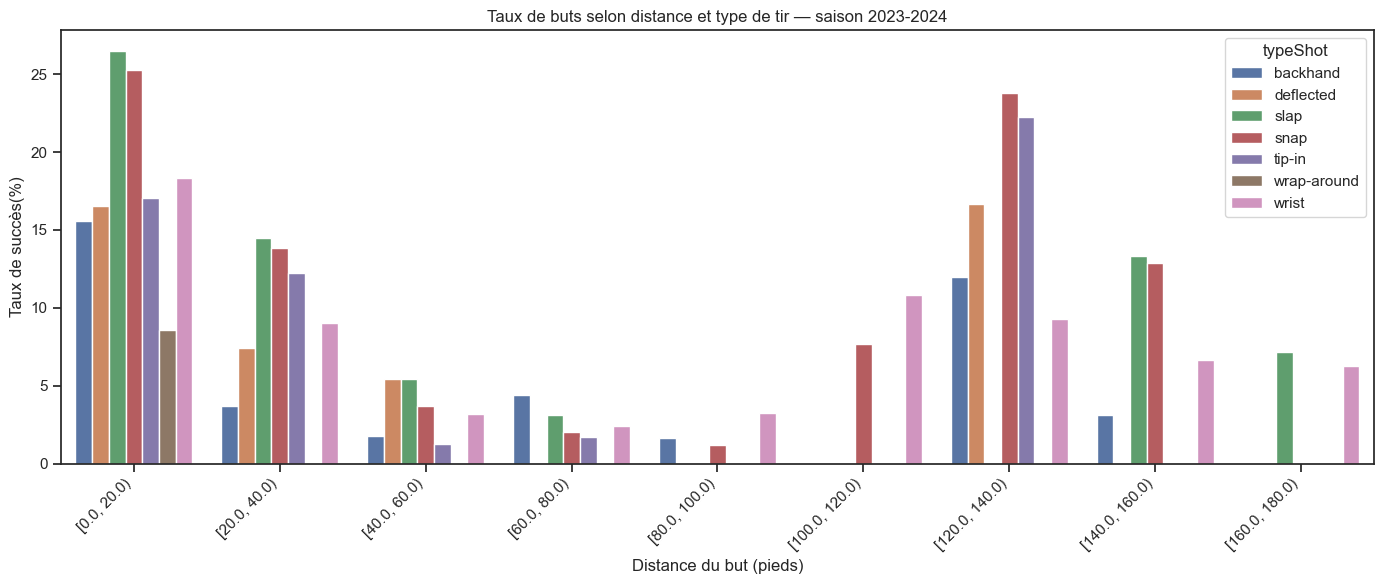

In [7]:
goal_rate_table = (
    shots_and_goals
    .groupby(["distance_bin", "typeShot"], observed=True, as_index=False)
    .agg(goal_rate=("isGoal", "mean"), shots=("isGoal", "size"),)
)

top_types = shots_and_goals["typeShot"].value_counts().head(7).index
filtered_table = goal_rate_table[goal_rate_table["typeShot"].isin(top_types)].copy()

# Labels distance
filtered_table["distance_label"] = filtered_table["distance_bin"].astype(str)

# en pourcentage
filtered_table["goal_pct"] = 100 * filtered_table["goal_rate"]

plt.figure(figsize=(14,6))
sns.barplot(data=filtered_table, x="distance_label", y="goal_pct", hue="typeShot")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Distance du but (pieds)")
plt.ylabel("Taux de succès(%)")
plt.title(f"Taux de buts selon distance et type de tir — saison {season}-{season+1}")
plt.tight_layout()
plt.show()